Data Loading and Preprocessing

In [1]:
import os
import pandas as pd
from tqdm import tqdm
from yaml import safe_load
import pickle
import numpy as np


data_dir = '/Users/nikhil/Desktop/Research_project/Research_project/t20s'


if not os.path.isdir(data_dir):
    print(f"Directory '{data_dir}' does not exist.")
else:
    filenames = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.yaml')]
    dfs = []

    for counter, file in tqdm(enumerate(filenames), desc="Processing files", total=len(filenames)):
        try:
            with open(file, 'r', encoding='utf-8') as f:
                df = pd.json_normalize(safe_load(f))
                df['match_id'] = counter + 1
                dfs.append(df)
        except Exception as e:
            print(f"Error processing file '{file}': {e}")

    final_df = pd.concat(dfs, ignore_index=True)
    pickle.dump(final_df, open('matches.pkl', 'wb'))


Processing files: 100%|██████████| 1432/1432 [01:22<00:00, 17.27it/s]


Utilizes a progress bar (tqdm) for visual tracking of file processing.
Opens each YAML file, reads its content, and normalizes it into a pandas DataFrame. Assigns a unique match_id to each match DataFrame.
Concatenates all individual match DataFrames into a single DataFrame, which is then serialized using pickle for future use.

Data Extraction

In [3]:
matches = pickle.load(open('matches.pkl', 'rb'))
delivery_data = []

for index, row in matches.iterrows():
    for delivery in row['innings'][0]['1st innings']['deliveries']:
        for ball_number, details in delivery.items():
            delivery_data.append({
                'match_id': row['match_id'],
                'batting_team': row['innings'][0]['1st innings']['team'],
                'ball': ball_number,
                'batsman': details['batsman'],
                'bowler': details['bowler'],
                'runs': details['runs']['total'],
                'player_dismissed': details.get('wicket', {}).get('player_out', '0'),
                'city': row['info.city'],
                'venue': row['info.venue']
            })

delivery_df = pd.DataFrame(delivery_data)
delivery_df.to_csv('delivery_data.csv', index=False)


Data Cleaning and Feature Engineering

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load the data
delivery_df = pd.read_csv('delivery_data.csv')
matches = pd.read_pickle('matches.pkl')

# Further process match details
matches['Date'] = pd.to_datetime(matches['info.dates'].str[0], errors='coerce')

# Merge delivery data with match details
combined_df = pd.merge(delivery_df, matches, on='match_id', how='inner')




In [5]:
combined_df.drop(columns=[
    'meta.data_version',
    'meta.created',
    'meta.revision',
    'info.outcome.bowl_out',
    'info.bowl_out',
    'info.supersubs.South Africa',
    'info.supersubs.New Zealand',
    'info.outcome.eliminator',
    'info.outcome.result',
    'info.outcome.method',
    'info.neutral_venue',
    'info.match_type_number',
    'info.outcome.by.runs',
    'info.outcome.by.wickets'
],inplace=True)

In [6]:
combined_df.head()

,match_id,batting_team,ball,batsman,bowler,runs,player_dismissed,city,venue,innings,...,info.match_type,info.outcome.winner,info.overs,info.player_of_match,info.teams,info.toss.decision,info.toss.winner,info.umpires,info.venue,Date
0,1,West Indies,0.1,HK Matthews,Diana Baig,0,HK Matthews,Canberra,Manuka Oval,"[{'1st innings': {'team': 'West Indies', 'deli...",...,T20,Pakistan,20,[Javeria Khan],"[Pakistan, West Indies]",bat,West Indies,"[CA Polosak, S George]",Manuka Oval,2020-02-26
1,1,West Indies,0.2,SR Taylor,Diana Baig,0,0,Canberra,Manuka Oval,"[{'1st innings': {'team': 'West Indies', 'deli...",...,T20,Pakistan,20,[Javeria Khan],"[Pakistan, West Indies]",bat,West Indies,"[CA Polosak, S George]",Manuka Oval,2020-02-26
2,1,West Indies,0.3,SR Taylor,Diana Baig,0,0,Canberra,Manuka Oval,"[{'1st innings': {'team': 'West Indies', 'deli...",...,T20,Pakistan,20,[Javeria Khan],"[Pakistan, West Indies]",bat,West Indies,"[CA Polosak, S George]",Manuka Oval,2020-02-26
3,1,West Indies,0.4,SR Taylor,Diana Baig,0,0,Canberra,Manuka Oval,"[{'1st innings': {'team': 'West Indies', 'deli...",...,T20,Pakistan,20,[Javeria Khan],"[Pakistan, West Indies]",bat,West Indies,"[CA Polosak, S George]",Manuka Oval,2020-02-26
4,1,West Indies,0.5,SR Taylor,Diana Baig,1,0,Canberra,Manuka Oval,"[{'1st innings': {'team': 'West Indies', 'deli...",...,T20,Pakistan,20,[Javeria Khan],"[Pakistan, West Indies]",bat,West Indies,"[CA Polosak, S George]",Manuka Oval,2020-02-26


In [7]:
combined_df=combined_df[combined_df['info.gender']=='male']

In [8]:
combined_df.drop(columns=['info.gender'],inplace=True)

/var/folders/zk/yt14z40j2lb2lz548fqr3v9m0000gn/T/ipykernel_10069/1927266342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df.drop(columns=['info.gender'],inplace=True)


In [9]:
combined_df = combined_df[combined_df['info.overs'] == 20]
combined_df.drop(columns=['info.overs','info.match_type'],inplace=True)

In [10]:
def bowl(row):
    for team in row['info.teams']:
        if team != row['batting_team']:
            return team

In [11]:
combined_df['bowling_team'] = combined_df.apply(bowl,axis=1)

In [12]:
teams = [
    'Australia',
    'India',
    'Bangladesh',
    'New Zealand',
    'South Africa',
    'England',
    'West Indies',
    'Afghanistan',
    'Pakistan',
    'Sri Lanka'
]

In [13]:
combined_df = combined_df[combined_df['batting_team'].isin(teams)]
combined_df = combined_df[combined_df['bowling_team'].isin(teams)]

In [14]:

columns = ['match_id', 'batting_team', 'ball', 'batsman', 'bowler', 'runs',
           'player_dismissed', 'city', 'venue', 'innings', 'info.city',
           'info.dates', 'info.outcome.winner', 'info.player_of_match',
           'info.toss.decision', 'info.toss.winner', 'info.umpires', 'info.venue',
           'Date', 'bowling_team']

# Create a dictionary to map old column names to new column names where 'info.' is removed
rename_dict = {col: col.replace('info.', '') for col in columns if 'info.' in col}

# Renaming the columns in the DataFrame
combined_df.rename(columns=rename_dict, inplace=True)

In [15]:
# Convert the 'Date' column to datetime format without indexing if it's already a string or datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')

In [16]:

if isinstance(combined_df['info.teams'].iloc[0], list):
    combined_df[['Team 1', 'Team 2']] = pd.DataFrame(combined_df['info.teams'].tolist(), index=combined_df.index)
    combined_df.drop(columns='info.teams', inplace=True)
else:
    print("Teams column is not in expected list format")

In [17]:
rename_columns = {
    'toss.winner': 'toss_winner',
    'outcome.winner': 'match_winner',
    'player_of_match': 'player_of_the_match',  
    'toss.decision': 'toss_decision'
}


combined_df.rename(columns=rename_columns, inplace=True)

In [18]:
combined_df.drop(columns='innings', inplace=True)

In [19]:
combined_df.drop(columns='umpires', inplace=True)

In [20]:
# Reorganizing columns to group related data together
organized_columns = [
    'match_id',
    'Team 1', 'Team 2',  # Grouping team information
    'batting_team', 'bowling_team',  # Further grouping team interaction
    'ball',   # Game progression details
    'batsman', 'bowler', 'runs', 'player_dismissed',  # Delivery-specific details
    'city', 'venue', 'Date',  # Location and time of the match
    'toss_winner', 'toss_decision',  # Toss details
    'match_winner', 'player_of_the_match' # Outcome details

]


combined_df = combined_df[organized_columns]


In [21]:
# Drop duplicate columns by selecting the first occurrence
combined_df = combined_df.loc[:,~combined_df.columns.duplicated()]

In [22]:
cities = np.where(combined_df['city'].isnull(),combined_df['venue'].str.split().apply(lambda x:x[0]),combined_df['city'])

In [23]:
combined_df['city'] = cities

In [24]:
# Remove rows where 'match_winner' is missing
initial_count = combined_df.shape[0]
combined_df.dropna(subset=['match_winner'], inplace=True)
final_count = combined_df.shape[0]

print(f"Dropped {initial_count - final_count} rows due to missing match winners.")


Dropped 2243 rows due to missing match winners.


In [25]:
combined_df.isnull().sum()

match_id                 0
Team 1                   0
Team 2                   0
batting_team             0
bowling_team             0
ball                     0
batsman                  0
bowler                   0
runs                     0
player_dismissed         0
city                     0
venue                    0
Date                     0
toss_winner              0
toss_decision            0
match_winner             0
player_of_the_match    365
dtype: int64

In [26]:
# Filtering the DataFrame to find rows where 'player_of_the_match' is null
null_potm_df = combined_df[combined_df['player_of_the_match'].isnull()]

# Count the initial number of rows for reference
initial_count = combined_df.shape[0]

# Drop rows where 'player_of_the_match' is NaN
combined_df.dropna(subset=['player_of_the_match'], inplace=True)

# Count the final number of rows to calculate how many were dropped
final_count = combined_df.shape[0]
rows_dropped = initial_count - final_count

Adding more match related features, such as crr, run rate etc.

In [27]:
combined_df['current_score'] = combined_df.groupby('match_id').cumsum()['runs']

/var/folders/zk/yt14z40j2lb2lz548fqr3v9m0000gn/T/ipykernel_10069/3779091949.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined_df['current_score'] = combined_df.groupby('match_id').cumsum()['runs']


In [28]:
combined_df['over'] = combined_df['ball'].apply(lambda x:str(x).split(".")[0])
combined_df['ball_no'] = combined_df['ball'].apply(lambda x:str(x).split(".")[1])

In [29]:
combined_df['balls_bowled'] = (combined_df['over'].astype('int')*6) + combined_df['ball_no'].astype('int')

In [30]:
combined_df['balls_left'] = 120 - combined_df['balls_bowled']
combined_df['balls_left'] = combined_df['balls_left'].apply(lambda x:0 if x<0 else x)

In [31]:
combined_df['player_dismissed'] = combined_df['player_dismissed'].apply(lambda x:0 if x=='0' else 1)
combined_df['player_dismissed'] = combined_df['player_dismissed'].astype('int')
combined_df['player_dismissed'] = combined_df.groupby('match_id').cumsum()['player_dismissed']
combined_df['wickets_left'] = 10 - combined_df['player_dismissed']

/var/folders/zk/yt14z40j2lb2lz548fqr3v9m0000gn/T/ipykernel_10069/380341676.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined_df['player_dismissed'] = combined_df.groupby('match_id').cumsum()['player_dismissed']


In [32]:
combined_df['crr'] = (combined_df['current_score']*6)/combined_df['balls_bowled']

In [33]:
groups = combined_df.groupby('match_id')

match_ids = combined_df['match_id'].unique()
last_five = []
for id in match_ids:
    last_five.extend(groups.get_group(id).rolling(window=30).sum()['runs'].values.tolist())

/var/folders/zk/yt14z40j2lb2lz548fqr3v9m0000gn/T/ipykernel_10069/1897754388.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date', 'Team 1', 'Team 2', 'batsman', 'batting_team', 'bowler',
       'bowling_team', 'city', 'match_winner', 'player_of_the_match',
       'toss_decision', 'toss_winner', 'venue'],
      dtype='object')
  last_five.extend(groups.get_group(id).rolling(window=30).sum()['runs'].values.tolist())


In [34]:
combined_df['last_five'] = last_five

In [35]:
combined_df.sample(10)

,match_id,Team 1,Team 2,batting_team,bowling_team,ball,batsman,bowler,runs,player_dismissed,...,match_winner,player_of_the_match,current_score,over,ball_no,balls_bowled,balls_left,wickets_left,crr,last_five
107845,893,Australia,South Africa,Australia,South Africa,17.5,BCJ Cutting,KJ Abbott,1,5,...,South Africa,[RR Rossouw],127,17,5,107,13,5,7.121495,34.0
11094,92,New Zealand,Australia,New Zealand,Australia,2.6,KS Williamson,KW Richardson,0,2,...,Australia,[B Stanlake],16,2,6,18,102,8,5.333333,NaN
58452,482,India,South Africa,South Africa,India,10.5,AB de Villiers,Harbhajan Singh,1,2,...,South Africa,[AB de Villiers],72,10,5,65,55,8,6.646154,26.0
87032,721,India,Australia,India,Australia,17.7,Washington Sundar,MA Starc,0,6,...,India,[YS Chahal],127,17,7,109,11,4,6.990826,36.0
76865,636,Australia,Sri Lanka,Australia,Sri Lanka,2.5,DA Warner,AD Mathews,0,2,...,Australia,[CL White],20,2,5,17,103,8,7.058824,NaN
119709,991,Australia,India,India,Australia,16.4,R Ashwin,DT Christian,4,6,...,Australia,[SR Watson],113,16,4,100,20,4,6.780000,35.0
95106,789,Pakistan,South Africa,South Africa,Pakistan,8.1,JP Duminy,Mohammad Hafeez,0,3,...,Pakistan,[Umar Gul],35,8,1,49,71,7,4.285714,21.0
128489,1062,Australia,India,Australia,India,13.5,SPD Smith,Washington Sundar,1,3,...,India,[HH Pandya],126,13,5,83,37,7,9.108434,46.0
4610,38,England,Australia,England,Australia,8.5,ME Trescothick,JN Gillespie,1,2,...,England,[KP Pietersen],76,8,5,53,67,8,8.603774,46.0
110432,914,Pakistan,Australia,Pakistan,Australia,17.4,Babar Azam,B Stanlake,1,6,...,Pakistan,[Imad Wasim],133,17,4,106,14,4,7.528302,32.0


In [36]:
combined_df.columns

Index(['match_id', 'Team 1', 'Team 2', 'batting_team', 'bowling_team', 'ball',
       'batsman', 'bowler', 'runs', 'player_dismissed', 'city', 'venue',
       'Date', 'toss_winner', 'toss_decision', 'match_winner',
       'player_of_the_match', 'current_score', 'over', 'ball_no',
       'balls_bowled', 'balls_left', 'wickets_left', 'crr', 'last_five'],
      dtype='object')

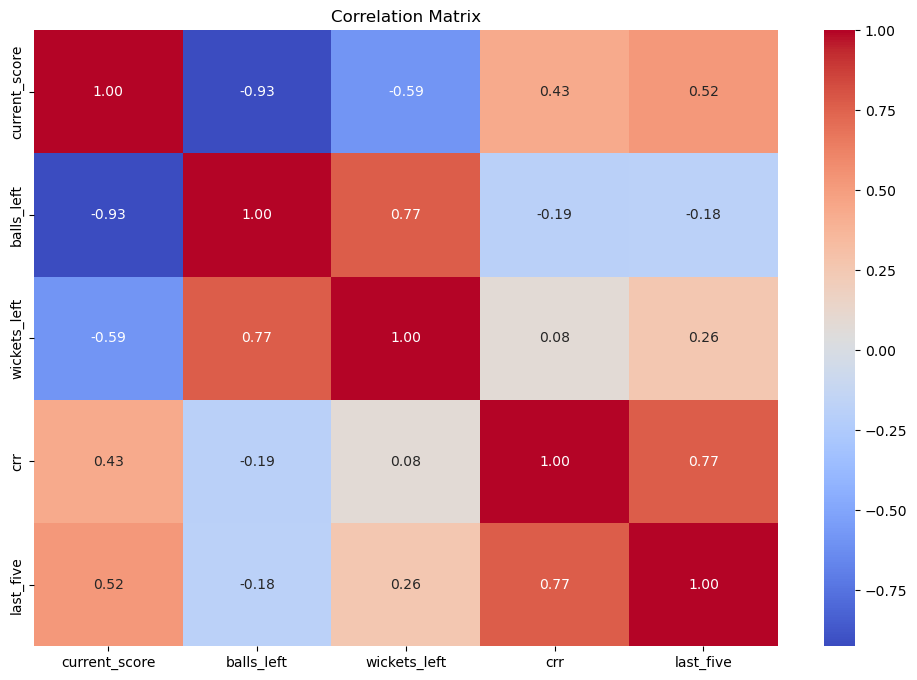

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Matrix of Numerical Features
numerical_features = ['current_score', 'balls_left', 'wickets_left', 'crr', 'last_five']
corr_matrix = combined_df[numerical_features].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

adding more features such as pressure factor , crr, wicket rate etc

In [38]:

combined_df.loc[:, 'run_rate'] = combined_df['current_score'] / (120 - combined_df['balls_left']) * 6
combined_df.loc[:, 'wickets_rate'] = combined_df['wickets_left'] / (120 - combined_df['balls_left']) * 6

# Using vectorized operations to create the Pressure Factor
combined_df.loc[:, 'pressure_factor'] = combined_df.apply(
    lambda row: row['last_five'] / (10 - row['wickets_left']) if row['wickets_left'] < 10 else row['last_five'],
    axis=1
)

In [39]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62133 entries, 245 to 173593
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   match_id             62133 non-null  int64         
 1   Team 1               62133 non-null  object        
 2   Team 2               62133 non-null  object        
 3   batting_team         62133 non-null  object        
 4   bowling_team         62133 non-null  object        
 5   ball                 62133 non-null  float64       
 6   batsman              62133 non-null  object        
 7   bowler               62133 non-null  object        
 8   runs                 62133 non-null  int64         
 9   player_dismissed     62133 non-null  int64         
 10  city                 62133 non-null  object        
 11  venue                62133 non-null  object        
 12  Date                 62133 non-null  datetime64[ns]
 13  toss_winner          62133 n

In [40]:
# Replace infinite or NaN values which may have been introduced
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.fillna(0, inplace=True)

model prepration and building 

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB




categorical_features = ['venue', 'batting_team', 'bowling_team', 'toss_decision','toss_winner']  
numerical_features = ['current_score', 'wickets_left', 'crr', 'last_five', 'run_rate', 'wickets_rate', 'pressure_factor'] 

# Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

def train_and_evaluate(model, X_train, X_test, y_train, y_test, force_dense=False):
    # Check if the model requires dense data
    if force_dense:
        # Add a step to convert data to dense format if required by the model
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Overall Accuracy:", accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    print("-" * 80)


X = combined_df.drop('match_winner', axis=1)
y = combined_df['match_winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models and whether they need dense data
models = [
    (SVC(kernel='rbf', random_state=42), False),
    (DecisionTreeClassifier(random_state=42), False),
    (GradientBoostingClassifier(n_estimators=100, random_state=42), False),
    (GaussianNB(), True)  
]

# Train and evaluate each model
for model, needs_dense in models:
    train_and_evaluate(model, X_train, X_test, y_train, y_test, force_dense=needs_dense)


Model: SVC
Overall Accuracy: 0.9817333226040074
              precision    recall  f1-score   support

 Afghanistan       1.00      0.98      0.99       156
   Australia       0.98      0.98      0.98      1609
  Bangladesh       1.00      0.95      0.97       342
     England       0.97      0.98      0.98      1446
       India       0.99      0.99      0.99      1771
 New Zealand       0.98      0.98      0.98      1358
    Pakistan       0.97      0.99      0.98      1813
South Africa       0.98      0.98      0.98      1516
   Sri Lanka       0.98      0.98      0.98      1272
 West Indies       0.98      0.97      0.98      1144

    accuracy                           0.98     12427
   macro avg       0.98      0.98      0.98     12427
weighted avg       0.98      0.98      0.98     12427

--------------------------------------------------------------------------------
Model: DecisionTreeClassifier
Overall Accuracy: 0.9928381749416593
              precision    recall  f1-score  

In [42]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Assuming 'toss_winner' and 'match_winner' are columns in your DataFrame
combined_df['toss_winner_wins'] = (combined_df['toss_winner'] == combined_df['match_winner']).astype(int)

# Create a contingency table
contingency_table = pd.crosstab(combined_df['toss_decision'], combined_df['toss_winner_wins'])

# Perform the chi-squared test
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}, p-value: {p}")

# Logistic regression to estimate the impact of toss_decision on winning
model = logit("toss_winner_wins ~ C(toss_decision)", data=combined_df).fit()
print(model.summary())


Chi-squared: 29.981615350526276, p-value: 4.361620827683187e-08
Optimization terminated successfully.
         Current function value: 0.692903
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:       toss_winner_wins   No. Observations:                62133
Model:                          Logit   Df Residuals:                    62131
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Jul 2024   Pseudo R-squ.:               0.0003491
Time:                        12:31:10   Log-Likelihood:                -43052.
converged:                       True   LL-Null:                       -43067.
Covariance Type:            nonrobust   LLR p-value:                 4.162e-08
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept     


 
The chi-squared test result is highly significant (p-value < 0.05), indicating a statistically significant association between the toss decision (bat or bowl) and the outcome of the match. This suggests that the decision made at the toss does impact whether the toss-winning team will win the match.

Logistic Regression Analysis
Pseudo R-squared: 0.0003491 (This is very low, indicating that the model explains very little of the variance in the outcome. Toss decisions, while statistically significant, might not be strongly predictive of match outcomes on their own.)
Coefficients:
Intercept: 0.0521 (When the reference category for the toss decision is "bat")
C(toss_decision)[T.field]: -0.0883
Coefficients Interpretation
The coefficient for C(toss_decision)[T.field] is -0.0883, which is statistically significant (p-value < 0.05). This suggests that choosing to field after winning the toss is associated with a decrease in the likelihood of winning the match compared to choosing to bat.
The negative sign indicates that teams that decide to field after winning the toss are slightly less likely to win the match than those that decide to bat.

In [44]:

odds_ratio = np.exp(-0.0883)
print(f"Odds Ratio: {odds_ratio}")


Odds Ratio: 0.9154861896654275


The analysis suggests that there is a statistically significant impact of the toss decision on the match outcome, with teams choosing to bat after winning the toss having a slightly higher likelihood of winning. This could inform strategic decisions in match play, although the effect size is relatively small, indicating that while the decision is statistically significant, its practical impact might be limited.